In [143]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import warnings
from tqdm import tqdm
import seaborn as sns
import datetime 
random_state =537

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

class config:
    #False
    otv = False # Belki sıçramalar bir daha denk gelinmicek tatil verisi olarak işaretlenebilir
    usd = False #brent içindeki doğru onu alıcam
    #True
    brent = True
    volume = True
    #Koşullu True
    platts = True # son 23 gün yok  direkt 2023 den sonrası istiyebiliriz
    depo_pump_imm = True# son 23 gün yok  direkt 2023 den sonrası istiyebiliriz
    
    
    #models
    prophet2step = False
    prophetshifted = True #80742763.37495 direkt target üstünde 
    #config
    draw = False


In [144]:
train = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/cash_flow_train.csv")
sub = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/sample_submission.csv")
sample_submission = sub.copy()

target = "Net Cashflow from Operations"

# Data Reading And Graphs

In [145]:
if(config.otv):
    otv = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/otv.csv")
    if(config.draw):
        otv.groupby("ÖTV uygulanan Ürün Adı")["ÖTV "].plot()
        plt.show()  
    print(otv["ÖTV uygulanan Ürün Adı"].value_counts())
    otv = otv.groupby("Tarih").mean()
    if(config.draw):
        otv["ÖTV "].plot()
    #otv_dict = dict(zip(otv.index,otv["ÖTV "]))
    #train["ötv_mean"] = train.Date.map(otv_dict) #83 tane veri var normalde 130 gün zaten


In [146]:
if(config.brent):
    brent = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/brent.csv")
    brent["TL Karşılıgı"] = brent["AB Piyasa Fiyatı"]*brent["Dolar Kuru (Satış)"] 
    brent.Tarih = pd.to_datetime(brent.Tarih)
    brent.set_index(brent.Tarih,drop=True,inplace=True)
    brent = brent.loc[:,["AB Piyasa Fiyatı","Dolar Kuru (Satış)","TL Karşılıgı"]]
    if(config.draw):
        for i in brent.columns:
            print("*"*25,i)
            brent[i].plot()
            plt.show()
    brent_dict = dict(zip(brent.index,brent["TL Karşılıgı"]))
    train["brent_tl"] = train.Date.map(brent_dict)
    
    brent_dict = dict(zip(brent.index,brent["AB Piyasa Fiyatı"]))
    train["brent_dolar"] = train.Date.map(brent_dict)
    
    brent_dict = dict(zip(brent.index,brent["Dolar Kuru (Satış)"]))
    train["Dolar Kuru (Satış)"] = train.Date.map(brent_dict)

In [147]:
if(config.usd):
    usd = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/usd.csv")
    usd.Tarih = pd.to_datetime(usd.Tarih)
    usd.set_index(usd.Tarih,drop=True,inplace=True)
    if(config.draw):
        for i in usd.columns:
            if(i == "Yıl" or i =="Tarih" or i.split(" ")[1] == "ALIŞ"):
                continue
            print("*"*25,i)
        usd[i].plot()
        #plt.show()

In [148]:
if(config.platts):
    platts = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/platts.csv")
    platts["TL Karşılıgı"] = platts["AB Piyasa Fiyatı"]*platts["Dolar Kuru (Satış)"] 
    platts.Tarih = pd.to_datetime(platts.Tarih)
    platts.set_index(platts.Tarih,drop=True,inplace=True)
    platts = platts.loc[:,["Ürün","AB Piyasa Fiyatı","Dolar Kuru (Satış)","TL Karşılıgı"]]
    if(config.draw):
        for i in platts.columns:
            if(i == "Ürün" or i == "Dolar Kuru (Satış)"):
                continue
            print("*"*25,i)
            platts.groupby("Ürün")[i].plot()
            plt.show()
    for i in platts.Ürün.unique():
        platts_c = platts.loc[platts.Ürün == i,:].copy() 
        platts_dict = dict(zip(platts_c.index,platts_c["TL Karşılıgı"]))
        train[f"{i}_tl"] = train.Date.map(platts_dict)

        platts_dict = dict(zip(platts_c.index,platts_c["AB Piyasa Fiyatı"]))
        train[f"{i}_dolar"] = train.Date.map(platts_dict)

In [149]:
if(config.depo_pump_imm ):
    depo_pump_imm = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/depo_pump_imm.csv")
    depo_pump_imm["Ay"] = depo_pump_imm.Ay.astype(str).apply(lambda x:"0"+x if len(x) == 1 else x)
    depo_pump_imm["Yıl"] = depo_pump_imm["Yıl"].astype(str)
    depo_pump_imm["Tarih_2"] = depo_pump_imm["Yıl"]+"-"+depo_pump_imm["Ay"]
    
    train["Tarih_2"] = train.Date.apply(lambda x:x[:-3])
    
    for i in depo_pump_imm.columns:
        if(i == "Yıl" or i == "Ay" or i=="Tarih_2"):
            continue
        depo_pump_imm[i] = depo_pump_imm[i].apply(lambda x:x.strip().replace(".","").replace(",",".")).astype(float)        
    
    dpi_dict = dict(zip(depo_pump_imm.Tarih_2,depo_pump_imm["IMM TL/m3"]))
    train["IMM TL/m3"] = train.Tarih_2.map(dpi_dict)
    
    dpi_dict = dict(zip(depo_pump_imm.Tarih_2,depo_pump_imm["Pump Price"]))
    train["Pump Price"] = train.Tarih_2.map(dpi_dict)
    
    dpi_dict = dict(zip(depo_pump_imm.Tarih_2,depo_pump_imm["Depot Price"]))
    train["Depot Price"] = train.Tarih_2.map(dpi_dict)
    
    train.drop(["Tarih_2"],axis=1,inplace=True)
    
    if(config.draw):
        depo_pump_imm.Tarih_2 = pd.to_datetime(depo_pump_imm.Tarih_2)
        depo_pump_imm.set_index(depo_pump_imm.Tarih_2,drop=True,inplace=True)
        for i in depo_pump_imm.columns:
            if(i == "Yıl" or i == "Ay" or i == "Tarih_2"):
                continue
            print("*"*25,i)
            depo_pump_imm[i].plot()
            plt.show()
    

In [150]:
if(config.volume):
    volume = pd.read_csv("/kaggle/input/new-shell-cashflow-datathon-2023/volume.csv")
    print("Number of unique values;\n","Posting date:",volume["Posting date"].nunique(),"Material Description:",volume["Material Description"].nunique(),"Product:",volume["Product"].nunique(),"Category:",volume["Category"].nunique(),sep="---")
    df = volume.groupby(["Category","Posting date"]).mean()["Sales Volumes in L15"].reset_index()
    if(config.draw):
        pd.pivot_table(df,
               index='Posting date', columns='Category', values='Sales Volumes in L15').plot(subplots=True,figsize=(15,15))
    for i in df.Category.unique():
        volume_dict = dict(zip(df[df.Category == i]["Posting date"],df[df.Category == i]["Sales Volumes in L15"]))
        train[f"{i}_Sales Volumse in L15"] = train.Date.map(volume_dict)

Number of unique values;
---Posting date:---1487---Material Description:---1115---Product:---1119---Category:---6


In [151]:
if(config.draw):
    corr = train.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Filling nan values

In [152]:
train.isna().sum()[train.isna().sum() != 0]

Inflows- currency                                    501
10 ppm ULSD CIF Med (Genova/Lavera)_tl                23
10 ppm ULSD CIF Med (Genova/Lavera)_dolar             23
Prem Unl 10 ppm CIF Med (Genova/Lavera)_tl            23
Prem Unl 10 ppm CIF Med (Genova/Lavera)_dolar         23
IMM TL/m3                                             23
Pump Price                                            23
Depot Price                                           23
LSC 600010_Sales Volumse in L15                       25
Lubricants 100034_Sales Volumse in L15                19
Shell Fleet Solutions 100018_Sales Volumse in L15    540
Undercanopy 800001_Sales Volumse in L15              207
dtype: int64

In [153]:
train.drop(["Shell Fleet Solutions 100018_Sales Volumse in L15","Undercanopy 800001_Sales Volumse in L15","Inflows- currency"],axis=1,inplace=True)
train.fillna(method="ffill",inplace=True)
train.isna().sum()[train.isna().sum() != 0]

Series([], dtype: int64)

# 1-)Prediction with prophet(2-step forecast)

In [154]:
# !pip install fbprophet

In [155]:
df_train , df_test , df_delete = train[train.Date <"2022-10-01"],train[(train.Date >"2022-10-01") &(train.Date <"2023-01-01")],train[train.Date >"2023-01-01"]
df_pred = pd.DataFrame()
df_pred["ds"] = df_test.Date
df_pred.reset_index(drop=True,inplace=True)
"train:",df_train.shape ,"test:",df_test.shape,"delete:",df_delete.shape

('train:', (937, 30), 'test:', (65, 30), 'delete:', (23, 30))

In [156]:
"brent_tl"
if(config.prophet2step):
    from prophet import Prophet
    model = Prophet()
    model.fit(df_train.rename(columns={"Date":"ds","brent_tl":"y"}))
    pred = model.predict(df_test.rename(columns={"Date":"ds","brent_tl":"y"}))
    #model.plot_components(pred,figsize=(5,5))
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.plot(pred.ds, pred['yhat'], color='black',label="pred")
    ax.plot(pd.to_datetime(df_test.Date), df_test['brent_tl'], color='r',label="actual")
    ax.legend()

# 2-)Prediction with prophet(shift70)

In [157]:
df_train , df_delete = train[train.Date <"2023-01-01"],train[train.Date >"2023-01-01"]

"train:",df_train.shape ,"delete:",df_delete.shape

('train:', (1002, 30), 'delete:', (23, 30))

In [158]:
shifted_test= df_train.iloc[-70:,16:].copy().reset_index(drop=True)
df_train.iloc[:,16:] = df_train.iloc[:,16:].shift(70)
df_train = df_train.iloc[70:,:]

In [159]:
df_test = pd.concat([sub.Date,shifted_test],axis=1)


  0%|          | 0/15 [00:00<?, ?it/s]16:02:00 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing

  7%|▋         | 1/15 [00:00<00:07,  1.76it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing

 13%|█▎        | 2/15 [00:01<00:07,  1.82it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:02 - cmdstanpy - INFO - Chain [1] done processing

 20%|██        | 3/15 [00:01<00:06,  1.83it/s]16:02:02 - cmdstanpy - INFO - Chain [1] start processing
16:02:02 - cmdstanpy - INFO - Chain [1] done processing

 27%|██▋       | 4/15 [00:02<00:06,  1.81it/s]16:02:03 - cmdstanpy - INFO - Chain [1] start processing
16:02:03 - cmdstanpy - INFO - Chain [1] done processing

 33%|███▎      | 5/15 [00:02<00:05,  1.85it/s]16:02:03 - cmdstanpy - INFO - Chain [1] start processing
16:02:03 - cmdstanpy - INFO - Chain [1] done processing

 40%|████      | 6/15 [00:03<00:04,  1.83it/s]1

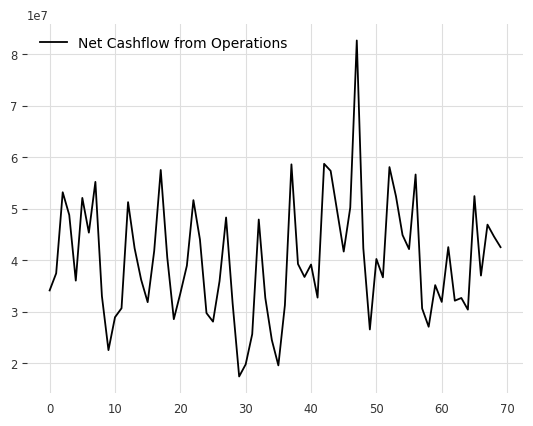

In [160]:
sample = sample_submission.copy()
if(config.prophetshifted):
    for i in tqdm(df_train.iloc[:,1:16].columns):
        from prophet import Prophet

        model = Prophet()

        for ii in df_train.iloc[:,16:].columns:
             model.add_regressor(ii)
        
        model.fit(df_train.rename(columns={"Date":"ds",i:"y"}))
        pred = model.predict(df_test.rename(columns={"Date":"ds",i:"y"}))
        sample[i] = pred["yhat"]
#         model.plot_components(pred,figsize=(5,5))

#         f, ax = plt.subplots(1)
#         f.set_figheight(5)
#         f.set_figwidth(15)
#         ax.plot(pd.to_datetime(train.Date),train[target])
#         ax.plot(pred.ds, pred['yhat'], color='black',label="pred")
#         ax.legend()
    inflow = ['Customers - DDS', 'Customers - EFT','T&S Collections', 'FX Sales', 'Other operations']
    # çıkartımı
    outflow = ['Tüpraş', 'Other Oil', 'Gas', 'Import payments (FX purchases)', 'Tax','Operatioınal and Admin. Expenses', 'VIS Buyback Payments']
        
    sample["total_inflow_pred"] = sample.loc[:,inflow].sum(axis=1)
    sample["total_outflow_pred"] = sample.loc[:,outflow].sum(axis=1)
    sample["result_cum"] = sample["total_inflow_pred"]+sample["total_outflow_pred"]
    sample["result_little_cum"] = sample["Total Inflows"]+sample["Total Outflows"]
    sample_submission[target] = sample.loc[:,[target,"result_cum","result_little_cum"]].mean(axis=1)
    sample_submission.to_csv("prophet_shifted_resultcumsum.csv",index=False)
    sample_submission.plot()

# 3-) Darts NbeastModel(past_covairtes)
-imputing
-2023 öncesi

In [161]:
# !pip install darts
# from darts import TimeSeries
# from darts.utils.timeseries_generation import (
#     gaussian_timeseries,
#     linear_timeseries,
#     sine_timeseries,
# )
# from darts.models import (
#     RNNModel,
#     TCNModel,
#     TransformerModel,
#     NBEATSModel,
#     BlockRNNModel,
#     VARIMA,
# )
# from darts.metrics import mape, smape, mae
# from darts.dataprocessing.transformers import Scaler
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

#date columns düşür future için test train birleşimi yap
#shell_datathon_lab işini görür



#shifted future,deleted past filan fistan varyasyon çok

In [162]:
train = train[train.Date <"2023-01-01"]

In [167]:
series_target =TimeSeries.from_series(train[target])
series_past = TimeSeries.from_dataframe(train.iloc[:,16:])

Scaler1 = Scaler()
series_target_scaler = Scaler1.fit_transform(series_target)
Scaler2 = Scaler()
series_past_scaler = Scaler2.fit_transform(series_past)

model = NBEATSModel(
    input_chunk_length=140, output_chunk_length=93, n_epochs=1, random_state=0
)
model.fit(series_target_scaler,past_covariates=series_past_scaler,verbose=True)
pred = model.predict(n=93,series=series_target_scaler,past_covariates=series_past_scaler)

a = Scaler1.inverse_transform(pred).pd_dataframe().values

# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# ax.plot(train.Date,train[target])
# ax.plot(sub.Date,sub[target],color="red")

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
sub.to_csv("dartsnbeaastfilledpastcov.csv",index=False)

In [ ]:
sub.describe()